In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_probability as tfp
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

def _preprocess(x):
    x = tf.cast(x=x, dtype=tf.float32) / 255.
    x = tf.reshape(tensor=x, shape=(28, 28, 1))
    x = tf.where(x > .5, 1.0, 0.0)
    return x, x

def get_ds(x):
    ds = tf.data.Dataset.from_tensor_slices(tensors=x)\
        .map(map_func=_preprocess)\
        .shuffle(buffer_size=len(x))\
        .batch(batch_size=256)\
        .cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train)
ds_test = get_ds(x=x_test)
ds_test.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))

In [7]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        prior = tfp.distributions.Independent(
            tfp.distributions.Normal(loc=tf.zeros(latent_dim), scale=1),
            reinterpreted_batch_ndims=1)

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2),
                padding='same', activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2),
                padding='same', activation=tf.keras.activations.relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(activation=None,
                units=tfp.layers.MultivariateNormalTriL.params_size(latent_dim)),
            tfp.layers.MultivariateNormalTriL(event_size=latent_dim,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior))
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Reshape(target_shape=(1, 1, latent_dim)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2),
                padding='same', activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2),
                padding='same', activation=tf.keras.activations.relu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(1, 1),
                padding='same', activation=None),
            tf.keras.layers.Flatten(),
            tfp.layers.IndependentBernoulli(event_shape=(28, 28, 1),
                convert_to_tensor_fn=tfp.distributions.Bernoulli.logits)
        ])

        def call(self, inputs, training=False):
            h = self.encoder(inputs=inputs)
            return self.decoder(inputs=h[0])

vae = CVAE(latent_dim=2)
vae.summary()

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_probability.python.layers.distribution_layer.MultivariateNormalTriL object at 0x7958761a7650> (of type <class 'tensorflow_probability.python.layers.distribution_layer.MultivariateNormalTriL'>)

In [14]:
%%bash

pip install -U tf_keras

In [16]:
import tensorflow as tf
import tf_keras as tfk
import tensorflow_probability as tfp

tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions

input_shape = (28, 28, 1)
encoded_size = 16
base_depth = 32

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [18]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 1, 64)          200768    
                                                                 
 flatten_2 (Flatten)         (None, 64)                0   

In [21]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(x=ds_train, validation_data=ds_test,
            epochs=15)

Epoch 1/15


I0000 00:00:1720709109.153108     603 service.cc:145] XLA service 0x7955ee05bbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720709109.153154     603 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
I0000 00:00:1720709109.296605     603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - 36s 63ms/step - loss: 209.7219 - val_loss: 156.5099
Epoch 2/15
235/235 [==============================] - 13s 55ms/step - loss: 147.4763 - val_loss: 141.0223
Epoch 3/15
235/235 [==============================] - 13s 55ms/step - loss: 135.3484 - val_loss: 129.0763
Epoch 4/15
235/235 [==============================] - 13s 55ms/step - loss: 124.4556 - val_loss: 121.7745
Epoch 5/15
235/235 [==============================] - 13s 55ms/step - loss: 118.4804 - val_loss: 115.9866
Epoch 6/15
235/235 [==============================] - 13s 55ms/step - loss: 114.0761 - val_loss: 111.4794
Epoch 7/15
235/235 [==============================] - 13s 55ms/step - loss: 111.8143 - val_loss: 111.6155
Epoch 8/15
235/235 [==============================] - 13s 56ms/step - loss: 109.6635 - val_loss: 108.9787
Epoch 9/15
235/235 [==============================] - 13s 55ms/step - loss: 108.1129 - val_loss: 107.2649
Epoch 10/15
235/235 [==============================] - 13

In [22]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Originals:


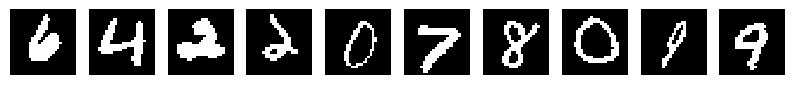

Decoded Random Samples:


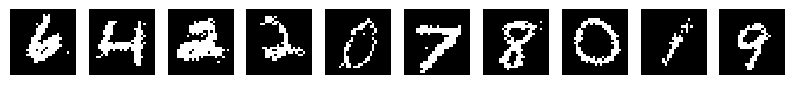

Decoded Modes:


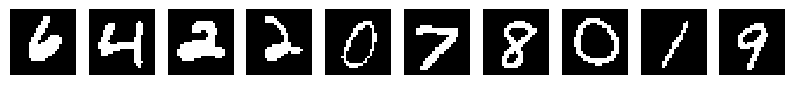

Decoded Means:


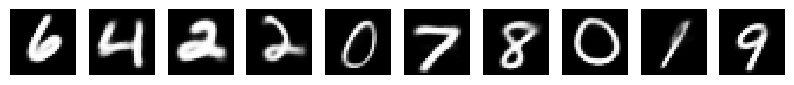

In [24]:
import numpy as np
# We'll just examine ten random digits.
x = next(iter(ds_test))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())